<a href="https://colab.research.google.com/github/bruckman/KISD_Statistics_ex-1/blob/master/LS_fit_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import collections as collections
from scipy import stats
from scipy import special
from scipy import integrate
from scipy import optimize

In [11]:
def gauss(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(x-mu)**2/(2*sigma**2))

def decay(x, tau):
    return np.exp(-x/tau) / tau

In [12]:
# \chi^2 = \sum(observed-expected)^2/expected
# when expected<0, the prediction is unphysical, we should set "expected" as a small positive number,
# for instance, set expected = 1e-6 

def chi2(mus, hist, bins, xmin=0, xmax=30.0, tau0=5.0, mu0=10.0, sigma0=3.0):
    chi2_val = 0.0
    
# length of dataset    
    n_bins = len(hist)
 
# define interval [a,b], a=i^{th} bin, b= i+1^{th} bin     
    for i in range(n_bins):
        a = bins[i]
        b = bins[i+1]
        
# integrate normalized signal PDF over [a,b]
        s_int, _ = integrate.quad(lambda x: gauss(x, mu0, sigma0) * scales, a, b)
        
# integrate normalized background PDF over [a,b]
        b_int, _ = integrate.quad(lambda x: decay(x, tau0) * scaleb, a, b)

# expected events = N_{signal}*integrated signal+N_{background}*integrated background,
# where N_{signal} = mus, N_{background}= N_histgram-N_{signal}
        expected = mus * s_int + (nhist - mus) * b_int
        observed = hist[i]
        
# avoid expected evnts<0
        if expected <= 0:
            expected = 1e-6  

# \chi^2=\sum_{(observed-expected)^2/expected}
        chi2_val += (observed - expected)**2 / expected
    return chi2_val

In [13]:
# define known constants
tau = 5.0
mu = 10.0
sigma = 3.0

# define some auxiliary parameters 
plow = 0.0
phig = 40.0
ndistr = 1000

# define the histogram
nbins=10
xrange = 30

x = np.linspace(0, xrange, ndistr)

# load the raw data from file
# nhist: background events+signal events
rndy = np.load("raw_data_3_tau5.npy")
nhist = len(rndy)

In [14]:
# find the p.d.f. normalisation factors for the considered interval (0,xrange) 
integrals = integrate.quad(gauss, 0, xrange, args=(mu, sigma))

# normalized constant of signal
print('integrals = ', integrals[0])
scales = 1/integrals[0]
integralb = integrate.quad(decay, 0, xrange, args=(tau,))

# normalized constant of background
print('integralb = ', integralb[0])
scaleb = 1/integralb[0]

# histogram the raw data
hy, binsy = np.histogram(rndy, bins=nbins, range=(0.0, xrange) )

integrals =  0.9995709396537192
integralb =  0.9975212478233337


In [15]:
# find the extremum of chi2
in_guess = [0,]
minimum = optimize.minimize(chi2, in_guess, args=(hy, binsy ,0.0, xrange, tau, mu, sigma))
fitted_mus = minimum.x[0]
print('extremum found for mus = ',fitted_mus)

extremum found for mus =  17.11409591605853


In [16]:
# set dummy uncertainties
sigma_neg = fitted_mus-10
sigma_pos = fitted_mus+10

# compute \chi^2
# evaluate \chi^2 over a grid of possible N_S values (pl)
# ll_array:stores \chi^2 for each N_S
pl = np.linspace(plow, phig, ndistr)
ll_array = []
for xx in pl:
   ll_array.append(chi2(xx, hy, binsy, 0.0, xrange, tau, mu, sigma))

# define \chi^2 threshold for 1\sigma uncertainty
chi2_min = minimum.fun
chi2_target = chi2_min + 1

# identify \chi^2 crossings
# find grid points where \chi^2<=\chi^2_{target} 
below_target = np.where(np.array(ll_array) <= chi2_target)[0]

if len(below_target) == 0:
    sigma_neg, sigma_pos = 0, 0
else:

# linear interpolation for precise bounds   
# solve of y = y_0+t(y_1-y_0) for t, where y = \chi^2-\chi^2_{target}
# calculate exact crossing: x_{bound} = x_0+t(x_1-x_0)
# left bound (sigma_neg)
# lower uncertainty
    left_idx = below_target[0]
    if left_idx > 0:
        x0, y0 = pl[left_idx - 1], ll_array[left_idx - 1] - chi2_target
        x1, y1 = pl[left_idx], ll_array[left_idx] - chi2_target
        t = -y0 / (y1 - y0)
        left_bound = x0 + t * (x1 - x0)
    else:
        left_bound = pl[left_idx]
    
# right bound (sigma_pos)
# upper uncertainty
    right_idx = below_target[-1]
    if right_idx < len(pl) - 1:
        x0, y0 = pl[right_idx], ll_array[right_idx] - chi2_target
        x1, y1 = pl[right_idx + 1], ll_array[right_idx + 1] - chi2_target
        t = -y0 / (y1 - y0)
        right_bound = x0 + t * (x1 - x0)
    else:
        right_bound = pl[right_idx]
    
    sigma_neg = fitted_mus - left_bound
    sigma_pos = right_bound - fitted_mus

print("-sigma = %2.3f,  +sigma = %2.3f"%(sigma_neg, sigma_pos))

-sigma = 7.384,  +sigma = 7.937


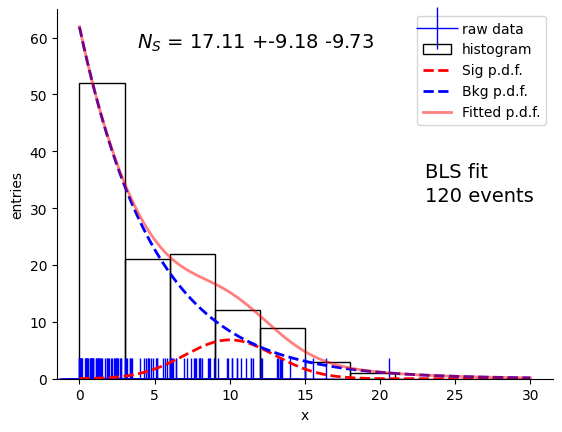

In [17]:
# fitted p.d.f.:
y = (fitted_mus/nhist*scales*gauss(x, mu, sigma)+(nhist-fitted_mus)/nhist*scaleb*decay(x, tau))
ys = (fitted_mus/nhist*scales*gauss(x, mu, sigma))
yb = ((nhist-fitted_mus)/nhist*scaleb*decay(x, tau))

fig, ax = plt.subplots()

ax.plot(rndy, np.zeros(rndy.shape), 'b+', ms=30, label="raw data")  # rug plot
ax.hist(rndy, bins=nbins, range=(0.0, xrange), fill=False, color='green', label="histogram")  # histogram

ax.plot(x, nhist*xrange*(1/nbins)*ys, 'r', linewidth=2, linestyle='--', label="Sig p.d.f.")
ax.plot(x, nhist*xrange*(1/nbins)*yb, 'b', linewidth=2, linestyle='--', label="Bkg p.d.f.")
ax.plot(x, nhist*xrange*(1/nbins)*y, 'r', alpha=0.5, linewidth=2, linestyle='-', label="Fitted p.d.f.")
#ax.set_ylim(bottom=0)

fig.text(0.70, 0.53, 'BLS fit', fontsize=14)
fig.text(0.70, 0.48, '%d events'%nhist, fontsize=14)
fig.text(0.25, 0.80, '$N_S$ = %2.2f +%2.2f -%2.2f'%(fitted_mus,sigma_pos-fitted_mus,fitted_mus-sigma_neg), fontsize=14)
#fig.text(0.25, 0.80, '$N_S$ = %2.2f'%(fitted_mus), fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.legend(loc=1, fontsize=10)

ax.set_xlabel('x')
ax.set_ylabel('entries')

plt.show()